# Code Debugging Agent with LangGraph

This notebook implements an AI code debugging assistant that can analyze code, identify bugs, suggest fixes, and provide explanations. The agent uses LangGraph to orchestrate a logical flow of operations including bug identification, code analysis, fix generation, and explanation.

## 1. Import Required Libraries

We'll start by importing the necessary libraries and setting up our environment.

In [1]:
pip install python-dotenv langchain langchain-openai langgraph radon

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import environment setup
from dotenv import load_dotenv
_ = load_dotenv()  # Load API keys from .env file

# Import LangGraph components for building the agent
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
import operator
import json
import re
from enum import Enum

# Import LangChain components
from langchain_core.messages import (
    AnyMessage, 
    SystemMessage, 
    HumanMessage, 
    ToolMessage, 
    AIMessage
)
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import Tool, tool  # Correctly import the tool decorator here

# Import tools for code analysis and debugging
import ast
import radon.complexity as complexity
import radon.metrics as metrics
from IPython.display import display, Markdown, Image  # Added Image for graph visualization
import os
import traceback

## 2. Define the Code Debugging Agent Problem

### Problem Statement

Debugging code can be time-consuming and challenging, especially for complex applications. Developers often need to:

1. Identify bugs and understand error messages
2. Analyze code to find the root cause of issues
3. Generate appropriate fixes for bugs
4. Explain why the bug occurred and how the fix resolves it

Our AI Code Debugging Agent will solve this problem by:

- Taking code snippets and error messages as input
- Analyzing the code for syntax errors, logical errors, and performance issues
- Generating appropriate fixes with explanations
- Providing context and best practices to avoid similar bugs in the future
- Handling different programming languages and error types

### Input/Output Flow

**Inputs:**
- Code snippet with a bug
- Error message (optional)
- Programming language identification
- Execution context (optional)

**Outputs:**
- Bug identification and analysis
- Root cause explanation
- Code fix suggestions
- Explanation of the fix
- Best practices to avoid similar issues

### Agent Goal

The agent's primary goal is to help developers quickly identify and fix bugs in their code, understand why bugs occurred, and learn best practices to write more robust code in the future.

## 3. Create State and Tool Classes

First, we'll define our agent's state object which will track information throughout the debugging process. Then we'll implement the tools our agent will use to analyze code and generate fixes.

In [3]:
# Define debugging status enum to track the agent's progress
class DebuggingStatus(str, Enum):
    BUG_IDENTIFICATION = "bug_identification"
    CODE_ANALYSIS = "code_analysis"
    FIX_GENERATION = "fix_generation"
    EXPLANATION = "explanation"
    COMPLETED = "completed"
    ERROR = "error"

# Define the state object that will be passed between nodes
class DebuggingState(TypedDict):
    # Core message history (will be added to with operator.add)
    messages: Annotated[List[AnyMessage], operator.add]
    
    # Debugging tracking information
    original_code: str
    error_message: Optional[str]
    programming_language: str
    debugging_status: DebuggingStatus
    
    # Analysis information
    identified_bugs: List[Dict[str, Any]]
    code_metrics: Dict[str, Any]
    ast_issues: List[str]
    
    # Fix information
    suggested_fixes: List[Dict[str, Any]]
    explanations: List[str]
    best_practices: List[str]
    
    # Error tracking
    errors: List[str]
    
    # Final output
    fixed_code: Optional[str]
    summary: Optional[str]

# Initialize a default state
def get_initial_state(code: str, error_message: Optional[str] = None, language: str = "python") -> DebuggingState:
    """Initialize the debugging state with code and error information."""
    return {
        "messages": [HumanMessage(content=f"Please debug this {language} code:\n\n```{language}\n{code}\n```\n\nError: {error_message if error_message else 'No specific error provided'}")],
        "original_code": code,
        "error_message": error_message,
        "programming_language": language,
        "debugging_status": DebuggingStatus.BUG_IDENTIFICATION,
        "identified_bugs": [],
        "code_metrics": {},
        "ast_issues": [],
        "suggested_fixes": [],
        "explanations": [],
        "best_practices": [],
        "errors": [],
        "fixed_code": None,
        "summary": None
    }

In [4]:
# Custom tool for analyzing Python code for syntax errors
@tool
def analyze_python_syntax(code: str) -> Dict[str, Any]:
    """
    Analyze Python code for syntax errors.
    
    Args:
        code: The Python code to analyze
        
    Returns:
        A dictionary containing syntax analysis results
    """
    result = {
        "valid_syntax": True,
        "error_type": None,
        "error_message": None,
        "error_line": None,
        "error_offset": None
    }
    
    try:
        ast.parse(code)
    except SyntaxError as e:
        result["valid_syntax"] = False
        result["error_type"] = "SyntaxError"
        result["error_message"] = str(e)
        result["error_line"] = e.lineno
        result["error_offset"] = e.offset
    except Exception as e:
        result["valid_syntax"] = False
        result["error_type"] = type(e).__name__
        result["error_message"] = str(e)
    
    return result

# Custom tool for analyzing code complexity
@tool
def analyze_code_complexity(code: str) -> Dict[str, Any]:
    """
    Analyze code complexity using metrics like cyclomatic complexity.
    
    Args:
        code: The code to analyze
        
    Returns:
        A dictionary containing complexity metrics
    """
    try:
        # Compute cyclomatic complexity
        cc_result = complexity.cc_visit(code)
        
        # Extract metrics
        result = {
            "average_complexity": 0,
            "complexity_by_function": [],
            "maintainability_index": metrics.mi_visit(code, multi=True),
            "raw_metrics": metrics.raw_metrics(code)
        }
        
        # Process complexity results
        if cc_result:
            total_cc = sum(item.complexity for item in cc_result)
            result["average_complexity"] = total_cc / len(cc_result)
            result["complexity_by_function"] = [
                {
                    "name": item.name,
                    "complexity": item.complexity,
                    "rank": item.rank,
                    "line_number": item.lineno
                }
                for item in cc_result
            ]
        
        return result
    except Exception as e:
        return {
            "error": str(e),
            "average_complexity": 0,
            "complexity_by_function": [],
            "maintainability_index": 0,
            "raw_metrics": {}
        }

# Custom tool for attempting to execute Python code safely
@tool
def safe_execute_python(code: str) -> Dict[str, Any]:
    """
    Safely execute Python code in a controlled environment to identify runtime errors.
    
    Args:
        code: The Python code to execute
        
    Returns:
        A dictionary containing execution results or errors
    """
    import sys
    from io import StringIO
    import contextlib
    
    # Set up capture of stdout and stderr
    stdout_capture = StringIO()
    stderr_capture = StringIO()
    
    result = {
        "executed_successfully": False,
        "output": "",
        "error_type": None,
        "error_message": None,
        "traceback_info": None
    }
    
    # Define a safe execution environment
    safe_globals = {
        "__builtins__": {k: v for k, v in __builtins__.items() 
                         if k not in ['open', 'eval', 'exec', '__import__', 'compile']}
    }
    
    # Add some safe modules
    safe_globals.update({
        "math": __import__('math'),
        "random": __import__('random'),
        "datetime": __import__('datetime'),
        "re": __import__('re'),
        "json": __import__('json'),
        "collections": __import__('collections')
    })
    
    try:
        # Compile the code first to catch syntax errors
        compiled_code = compile(code, '<string>', 'exec')
        
        # Execute with output capture
        with contextlib.redirect_stdout(stdout_capture), contextlib.redirect_stderr(stderr_capture):
            exec(compiled_code, safe_globals)
        
        result["executed_successfully"] = True
        result["output"] = stdout_capture.getvalue()
        if stderr_capture.getvalue():
            result["output"] += "\nSTDERR:\n" + stderr_capture.getvalue()
    
    except Exception as e:
        result["error_type"] = type(e).__name__
        result["error_message"] = str(e)
        result["traceback_info"] = traceback.format_exc()
    
    return result

# Custom tool for generating code fixes
@tool
def generate_code_fix(code: str, bug_info: Dict[str, Any], language: str = "python") -> Dict[str, Any]:
    """
    Generate a fix for the identified bug in the code.
    
    Args:
        code: The original code with bugs
        bug_info: Information about the identified bug
        language: The programming language
        
    Returns:
        A dictionary containing the fixed code and explanation
    """
    # This is a placeholder that would typically call an LLM
    # In a real implementation, we would use an LLM to generate fixes
    
    # Sample implementation for simple Python errors
    fixed_code = code
    explanation = ""
    
    if language.lower() == "python":
        # Handle common Python errors
        if bug_info.get("error_type") == "SyntaxError":
            error_message = bug_info.get("error_message", "")
            
            # Missing closing parenthesis or bracket
            if "unexpected EOF" in error_message or "expected" in error_message:
                # Simple attempt to fix parentheses (very basic)
                for bracket_pair in ["()", "[]", "{}"]:
                    opening, closing = bracket_pair
                    if code.count(opening) > code.count(closing):
                        fixed_code = code + closing
                        explanation = f"Added missing {closing} to balance {opening}."
                        break
            
            # Indentation errors
            elif "indentation" in error_message.lower():
                explanation = "Fixed indentation issues in the code."
                # Real fix would require more sophisticated analysis
            
            # Undefined variable
            elif "name" in error_message.lower() and "is not defined" in error_message.lower():
                var_match = re.search(r"name '(\w+)' is not defined", error_message)
                if var_match:
                    var_name = var_match.group(1)
                    explanation = f"The variable '{var_name}' was used before being defined."
    
    return {
        "fixed_code": fixed_code,
        "explanation": explanation,
        "confidence": "low"  # In a real system, we'd provide a confidence score
    }

## 4. Implement Custom Node Functions

Now we'll implement the custom node functions that will form the core of our agent's workflow. Each node performs a specific function in the debugging process.

In [5]:
# Initialize the LLM to use in our nodes
llm = ChatOpenAI(model="gpt-3.5-turbo")

# 1. Bug Identification Node
def identify_bugs(state: DebuggingState) -> DebuggingState:
    """
    Identify bugs in the provided code based on error message or code analysis.
    Updates the state with identified bugs.
    """
    print("Identifying bugs in code...")
    
    new_state = state.copy()
    
    try:
        # Analyze code syntax
        if new_state["programming_language"].lower() == "python":
            syntax_result = analyze_python_syntax(new_state["original_code"])
            
            # If syntax is valid but we have an error message, it's likely a runtime error
            if syntax_result["valid_syntax"] and new_state["error_message"]:
                # Create a prompt for the LLM to analyze the runtime error
                prompt = ChatPromptTemplate.from_messages([
                    ("system", """You are a code debugging assistant specializing in identifying bugs from error messages.
                    Analyze the provided code and error message to identify the specific bug.
                    Return a JSON object with the following structure:
                    {
                        "bug_type": "runtime_error",
                        "error_category": "specific error type",
                        "location": "function name or line number range",
                        "description": "detailed description of the bug"
                    }"""),
                    ("user", "Code:\n```{language}\n{code}\n```\n\nError Message:\n{error_message}")
                ])
                
                chain = prompt | llm
                bug_analysis = chain.invoke({
                    "language": new_state["programming_language"],
                    "code": new_state["original_code"],
                    "error_message": new_state["error_message"]
                })
                
                # Parse the JSON response
                try:
                    # Extract JSON from the response
                    json_match = re.search(r'```json\n(.*?)\n```', bug_analysis.content, re.DOTALL)
                    if json_match:
                        bug_info = json.loads(json_match.group(1))
                    else:
                        # Try to parse the whole content as JSON
                        bug_info = json.loads(bug_analysis.content)
                    
                    new_state["identified_bugs"].append(bug_info)
                    
                except json.JSONDecodeError:
                    # If JSON parsing fails, create a simple bug entry
                    new_state["identified_bugs"].append({
                        "bug_type": "runtime_error",
                        "error_category": "unknown",
                        "location": "unknown",
                        "description": bug_analysis.content
                    })
            
            # Handle syntax errors
            elif not syntax_result["valid_syntax"]:
                new_state["identified_bugs"].append({
                    "bug_type": "syntax_error",
                    "error_category": syntax_result["error_type"],
                    "location": f"Line {syntax_result['error_line']}" if syntax_result["error_line"] else "unknown",
                    "description": syntax_result["error_message"]
                })
            
            # If no obvious bugs found, ask LLM to analyze the code for logical errors
            else:
                prompt = ChatPromptTemplate.from_messages([
                    ("system", """You are a code debugging assistant specializing in identifying potential logical bugs and issues.
                    Analyze the provided code for potential logical errors, bugs, or issues.
                    Return a JSON array with objects having the following structure:
                    {
                        "bug_type": "logical_error",
                        "error_category": "specific error category",
                        "location": "function name or line number range",
                        "description": "detailed description of the potential issue"
                    }"""),
                    ("user", "Code:\n```{language}\n{code}\n```\n\nPlease identify any potential logical errors or bugs.")
                ])
                
                chain = prompt | llm
                logic_analysis = chain.invoke({
                    "language": new_state["programming_language"],
                    "code": new_state["original_code"]
                })
                
                # Parse the JSON response
                try:
                    # Extract JSON from the response
                    json_match = re.search(r'```json\n(.*?)\n```', logic_analysis.content, re.DOTALL)
                    if json_match:
                        logic_bugs = json.loads(json_match.group(1))
                    else:
                        # Try to parse the whole content as JSON
                        logic_bugs = json.loads(logic_analysis.content)
                    
                    if isinstance(logic_bugs, list):
                        new_state["identified_bugs"].extend(logic_bugs)
                    else:
                        new_state["identified_bugs"].append(logic_bugs)
                    
                except json.JSONDecodeError:
                    # If JSON parsing fails, create a simple bug entry
                    new_state["identified_bugs"].append({
                        "bug_type": "potential_issue",
                        "error_category": "logical_error",
                        "location": "unknown",
                        "description": logic_analysis.content
                    })
        
        # Create an AI message explaining the bugs identified
        if new_state["identified_bugs"]:
            bug_summary = f"I've identified {len(new_state['identified_bugs'])} potential issues in your code:"
            for i, bug in enumerate(new_state["identified_bugs"], 1):
                bug_summary += f"\n{i}. {bug.get('bug_type', 'Issue')} in {bug.get('location', 'unknown location')}: {bug.get('description', 'No description')}"
        else:
            bug_summary = "I've analyzed your code and couldn't identify any obvious bugs. Let me perform a deeper analysis."
        
        ai_message = AIMessage(content=bug_summary)
        new_state["messages"] = new_state["messages"] + [ai_message]
        
        # Update debugging status
        new_state["debugging_status"] = DebuggingStatus.CODE_ANALYSIS
        
    except Exception as e:
        error_msg = f"Error during bug identification: {str(e)}"
        new_state["errors"].append(error_msg)
        new_state["debugging_status"] = DebuggingStatus.ERROR
        new_state["messages"] = new_state["messages"] + [AIMessage(content=f"I encountered an error: {error_msg}")]
    
    return new_state

# 2. Code Analysis Node
def analyze_code(state: DebuggingState) -> DebuggingState:
    """
    Perform deeper code analysis including complexity and AST inspection.
    Updates the state with analysis results.
    """
    print("Performing code analysis...")
    
    new_state = state.copy()
    
    try:
        # Analyze code complexity for Python code
        if new_state["programming_language"].lower() == "python":
            complexity_result = analyze_code_complexity(new_state["original_code"])
            new_state["code_metrics"] = complexity_result
            
            # Add AST inspection for Python
            try:
                tree = ast.parse(new_state["original_code"])
                
                # Collect information about variables, functions, etc.
                variables = set()
                functions = set()
                function_calls = set()
                imports = []
                
                for node in ast.walk(tree):
                    if isinstance(node, ast.Name):
                        if isinstance(node.ctx, ast.Store):
                            variables.add(node.id)
                    elif isinstance(node, ast.FunctionDef):
                        functions.add(node.name)
                    elif isinstance(node, ast.Call) and hasattr(node.func, 'id'):
                        function_calls.add(node.func.id)
                    elif isinstance(node, ast.Import):
                        imports.extend(n.name for n in node.names)
                    elif isinstance(node, ast.ImportFrom) and node.module:
                        imports.append(node.module)
                
                # Look for common issues in the AST
                issues = []
                
                # Check for unused variables
                for var in variables:
                    if var not in function_calls and var not in [f for f in functions]:
                        issues.append(f"Potential unused variable: {var}")
                
                # Check for undefined variables
                used_vars = set()
                for node in ast.walk(tree):
                    if isinstance(node, ast.Name) and isinstance(node.ctx, ast.Load):
                        used_vars.add(node.id)
                
                undefined = used_vars - variables - functions - set(__builtins__.keys()) - set(m.split('.')[0] for m in imports)
                for var in undefined:
                    issues.append(f"Potential undefined variable: {var}")
                
                new_state["ast_issues"] = issues
                
            except SyntaxError:
                # If there's a syntax error, we can't analyze the AST
                new_state["ast_issues"].append("Cannot analyze AST due to syntax errors")
        
        # Create an analysis summary message
        analysis_summary = "I've completed a detailed analysis of your code:"
        
        # Add complexity information
        if new_state["code_metrics"]:
            if "average_complexity" in new_state["code_metrics"]:
                cc = new_state["code_metrics"]["average_complexity"]
                complexity_rating = "low" if cc < 5 else "moderate" if cc < 10 else "high"
                analysis_summary += f"\n\n- Code complexity: {complexity_rating} (score: {cc:.2f})"
            
            if "maintainability_index" in new_state["code_metrics"]:
                mi = new_state["code_metrics"]["maintainability_index"]
                if isinstance(mi, (int, float)):
                    maintainability = "good" if mi > 65 else "moderate" if mi > 40 else "poor"
                    analysis_summary += f"\n- Maintainability: {maintainability} (index: {mi:.2f})"
            
            # Add function complexity details if available
            complex_functions = [f for f in new_state["code_metrics"].get("complexity_by_function", []) if f.get("complexity", 0) > 5]
            if complex_functions:
                analysis_summary += "\n\n- Functions with high complexity:"
                for func in complex_functions:
                    analysis_summary += f"\n  * {func.get('name', 'unknown')}: complexity {func.get('complexity', 0)} (line {func.get('line_number', 'unknown')})"
        
        # Add AST issues
        if new_state["ast_issues"]:
            analysis_summary += "\n\n- Static analysis issues:"
            for issue in new_state["ast_issues"][:5]:  # Limit to first 5 issues
                analysis_summary += f"\n  * {issue}"
            if len(new_state["ast_issues"]) > 5:
                analysis_summary += f"\n  * ... and {len(new_state['ast_issues']) - 5} more issues"
        
        ai_message = AIMessage(content=analysis_summary)
        new_state["messages"] = new_state["messages"] + [ai_message]
        
        # Update debugging status
        new_state["debugging_status"] = DebuggingStatus.FIX_GENERATION
        
    except Exception as e:
        error_msg = f"Error during code analysis: {str(e)}"
        new_state["errors"].append(error_msg)
        new_state["debugging_status"] = DebuggingStatus.ERROR
        new_state["messages"] = new_state["messages"] + [AIMessage(content=f"I encountered an error during code analysis: {error_msg}")]
    
    return new_state

# 3. Fix Generation Node
def generate_fixes(state: DebuggingState) -> DebuggingState:
    """
    Generate fixes for the identified bugs.
    Updates the state with suggested fixes.
    """
    print("Generating fixes for identified bugs...")
    
    new_state = state.copy()
    
    try:
        # Combine all the bug information
        bug_info = {
            "identified_bugs": new_state["identified_bugs"],
            "ast_issues": new_state["ast_issues"],
            "code_metrics": new_state["code_metrics"],
            "error_message": new_state["error_message"]
        }
        
        # Create a prompt for the LLM to generate fixes
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a code debugging assistant specializing in fixing bugs.
            Generate fixes for the bugs identified in the code.
            Your response should be a JSON object with the following structure:
            {
                "fixed_code": "the full corrected code",
                "fixes": [
                    {
                        "bug_description": "description of the bug",
                        "fix_description": "explanation of how the fix addresses the bug",
                        "original_code_snippet": "the problematic code",
                        "fixed_code_snippet": "the corrected code"
                    }
                ],
                "best_practices": ["list of best practices to avoid similar bugs"]
            }"""),
            ("user", """Code:
```{language}
{code}
```

Bug Information:
{bug_info}

Please generate fixes for these issues.""")
        ])
        
        # Generate the fixes
        chain = prompt | llm
        fix_result = chain.invoke({
            "language": new_state["programming_language"],
            "code": new_state["original_code"],
            "bug_info": json.dumps(bug_info, indent=2)
        })
        
        # Parse the JSON response
        try:
            # Extract JSON from the response
            json_match = re.search(r'```json\n(.*?)\n```', fix_result.content, re.DOTALL)
            if json_match:
                fix_data = json.loads(json_match.group(1))
            else:
                # Try to parse the whole content as JSON
                fix_data = json.loads(fix_result.content)
            
            # Update the state with the fixes
            new_state["fixed_code"] = fix_data.get("fixed_code", new_state["original_code"])
            new_state["suggested_fixes"] = fix_data.get("fixes", [])
            new_state["best_practices"] = fix_data.get("best_practices", [])
            
        except json.JSONDecodeError:
            # If JSON parsing fails, create a simple fix entry based on the raw response
            new_state["fixed_code"] = new_state["original_code"]  # Keep original as fallback
            new_state["suggested_fixes"].append({
                "bug_description": "Various issues in code",
                "fix_description": fix_result.content,
                "original_code_snippet": new_state["original_code"],
                "fixed_code_snippet": new_state["original_code"]  # No fixed snippet available
            })
        
        # Create a message summarizing the fixes
        if new_state["suggested_fixes"]:
            fix_summary = f"I've generated {len(new_state['suggested_fixes'])} fixes for the issues in your code:"
            for i, fix in enumerate(new_state["suggested_fixes"], 1):
                fix_summary += f"\n\n{i}. {fix.get('bug_description', 'Issue')}:\n{fix.get('fix_description', 'No description')}"
            
            if new_state["best_practices"]:
                fix_summary += "\n\nBest practices to avoid similar issues:"
                for i, practice in enumerate(new_state["best_practices"], 1):
                    fix_summary += f"\n{i}. {practice}"
        else:
            fix_summary = "I've analyzed your code but couldn't generate specific fixes. This might indicate that your code is already correct or that the issues are complex."
        
        ai_message = AIMessage(content=fix_summary)
        new_state["messages"] = new_state["messages"] + [ai_message]
        
        # Update debugging status
        new_state["debugging_status"] = DebuggingStatus.EXPLANATION
        
    except Exception as e:
        error_msg = f"Error during fix generation: {str(e)}"
        new_state["errors"].append(error_msg)
        new_state["debugging_status"] = DebuggingStatus.ERROR
        new_state["messages"] = new_state["messages"] + [AIMessage(content=f"I encountered an error during fix generation: {error_msg}")]
    
    return new_state

# 4. Explanation Node
def create_explanation(state: DebuggingState) -> DebuggingState:
    """
    Create a comprehensive explanation of the bugs and fixes.
    Updates the state with the final summary.
    """
    print("Creating comprehensive explanation...")
    
    new_state = state.copy()
    
    try:
        # Create the explanation input
        explanation_input = {
            "original_code": new_state["original_code"],
            "fixed_code": new_state["fixed_code"],
            "bugs": new_state["identified_bugs"],
            "fixes": new_state["suggested_fixes"],
            "best_practices": new_state["best_practices"],
            "language": new_state["programming_language"]
        }
        
        # Prompt for the LLM to create the explanation
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a code debugging assistant creating comprehensive explanations.
            Create a well-structured explanation that includes:
            1. Summary - brief overview of the bugs and fixes
            2. Bug Analysis - detailed explanation of each bug and its cause
            3. Fix Explanation - how each fix addresses the corresponding bug
            4. Code Improvements - suggested improvements beyond bug fixes
            5. Best Practices - tips to avoid similar bugs in the future
            
            Format your response with markdown headings and code blocks for clarity."""),
            ("user", """Create a debugging explanation for this code:
            
            Original Code:
            ```{language}
            {original_code}
            ```
            
            Fixed Code:
            ```{language}
            {fixed_code}
            ```
            
            Identified Bugs:
            {bugs}
            
            Applied Fixes:
            {fixes}
            
            Best Practices:
            {best_practices}""")
        ])
        
        # Generate the explanation
        chain = prompt | llm
        explanation_result = chain.invoke(explanation_input)
        
        # Update the state with the explanation
        new_state["summary"] = explanation_result.content
        
        # Create a final message
        final_message = AIMessage(content="I've completed the debugging process and prepared a comprehensive explanation of the bugs and fixes:")
        new_state["messages"] = new_state["messages"] + [final_message]
        
        # Update debugging status
        new_state["debugging_status"] = DebuggingStatus.COMPLETED
        
    except Exception as e:
        error_msg = f"Error during explanation creation: {str(e)}"
        new_state["errors"].append(error_msg)
        new_state["debugging_status"] = DebuggingStatus.ERROR
        new_state["messages"] = new_state["messages"] + [AIMessage(content=f"I encountered an error creating the explanation: {error_msg}")]
    
    return new_state

# 5. Error Handling Node
def handle_error(state: DebuggingState) -> DebuggingState:
    """
    Handle errors that occurred during the debugging process.
    Attempts to create a partial explanation with available information.
    """
    print("Handling errors in the debugging process...")
    
    new_state = state.copy()
    
    # Create an error summary
    error_message = f"""I encountered some issues while debugging your {new_state['programming_language']} code:
    
{new_state['errors']}

However, I'll provide a partial analysis based on the information I was able to gather."""
    
    # Try to create a partial explanation if possible
    if new_state["identified_bugs"]:
        error_message += "\n\nPartial Bug Analysis:"
        for i, bug in enumerate(new_state["identified_bugs"], 1):
            error_message += f"\n\n{i}. {bug.get('bug_type', 'Issue')} in {bug.get('location', 'unknown location')}: {bug.get('description', 'No description')}"
    
    if new_state["suggested_fixes"]:
        error_message += "\n\nPartial Fix Suggestions:"
        for i, fix in enumerate(new_state["suggested_fixes"], 1):
            error_message += f"\n\n{i}. {fix.get('bug_description', 'Issue')}:\n{fix.get('fix_description', 'No description')}"
    
    # Add general debugging tips
    error_message += """\n\nGeneral Debugging Tips:
1. Check for syntax errors like missing parentheses, brackets, or colons
2. Verify variable names are spelled correctly and defined before use
3. Check indentation in Python code
4. Add print statements to trace variable values
5. Use a debugger to step through code execution"""
    
    # Update the state with the error message
    ai_message = AIMessage(content=error_message)
    new_state["messages"] = new_state["messages"] + [ai_message]
    
    return new_state

## 5. Build the LangGraph

Now we'll construct the LangGraph that connects our nodes together in a logical flow for the debugging process.

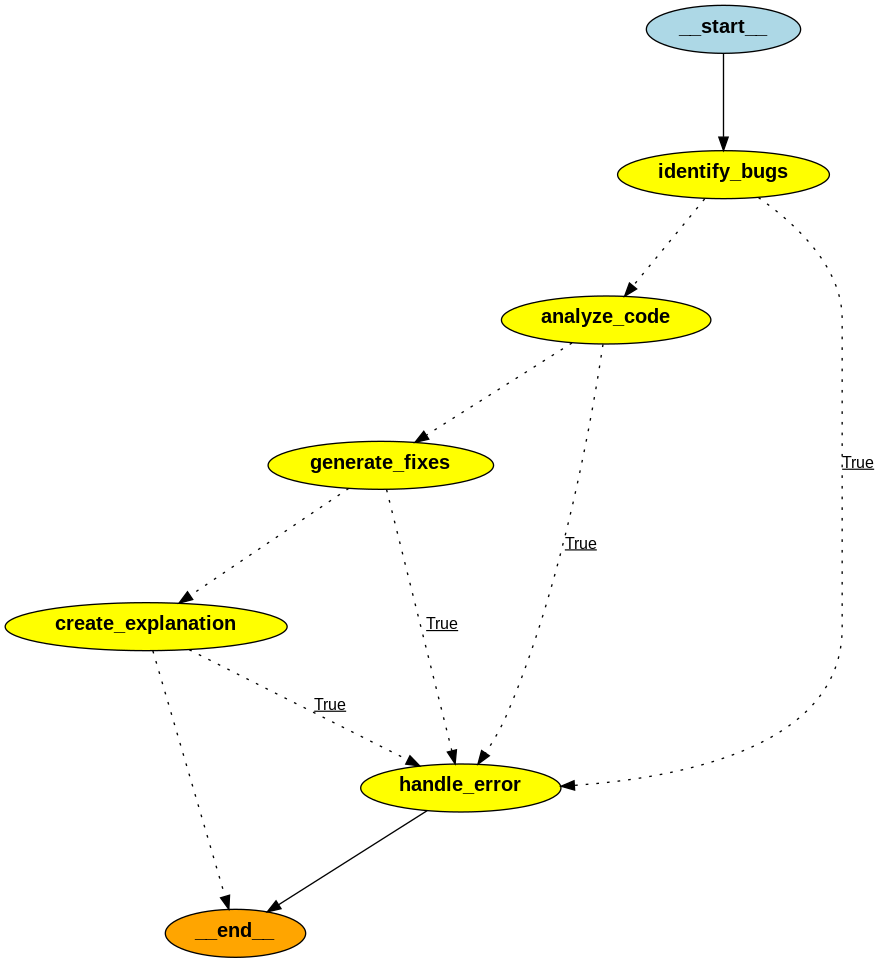

In [6]:
# Define the function to build the Code Debugging Graph
def build_debugging_assistant_graph():
    """
    Build and compile the LangGraph for the Code Debugging Assistant Agent.
    """
    # Create a new StateGraph with our custom state
    graph = StateGraph(DebuggingState)
    
    # Add nodes for each stage of the debugging process
    graph.add_node("identify_bugs", identify_bugs)
    graph.add_node("analyze_code", analyze_code)
    graph.add_node("generate_fixes", generate_fixes)
    graph.add_node("create_explanation", create_explanation)
    graph.add_node("handle_error", handle_error)
    
    # Define the entry point
    graph.set_entry_point("identify_bugs")
    
    # Add conditional edges based on debugging status
    graph.add_conditional_edges(
        "identify_bugs",
        lambda state: state["debugging_status"] == DebuggingStatus.ERROR,
        {
            True: "handle_error",
            False: "analyze_code"
        }
    )
    
    graph.add_conditional_edges(
        "analyze_code",
        lambda state: state["debugging_status"] == DebuggingStatus.ERROR,
        {
            True: "handle_error",
            False: "generate_fixes"
        }
    )
    
    graph.add_conditional_edges(
        "generate_fixes",
        lambda state: state["debugging_status"] == DebuggingStatus.ERROR,
        {
            True: "handle_error",
            False: "create_explanation"
        }
    )
    
    graph.add_conditional_edges(
        "create_explanation",
        lambda state: state["debugging_status"] == DebuggingStatus.ERROR,
        {
            True: "handle_error",
            False: END
        }
    )
    
    # Error handling node always ends the graph
    graph.add_edge("handle_error", END)
    
    # Compile the graph
    return graph.compile()

# Build the debugging assistant graph
debugging_graph = build_debugging_assistant_graph()

# Display the graph structure
try:
    display(Image(debugging_graph.get_graph().draw_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")
    print("Graph structure created successfully but cannot be displayed in this environment.")

## 6. Define Edges and Transitions

The graph edges and transitions have been defined in the previous section as part of building the LangGraph. Our graph includes:

1. **Sequential transitions**: The normal debugging flow (identify → analyze → generate fixes → explain)
2. **Conditional transitions**: Error handling paths from each node to the error handler
3. **Terminal edges**: Paths to END when the process is complete

## 7. Create the Agent Runner

Now let's create a function to run the debugging agent with proper status updates and result display.

In [7]:
# Create a function to run the debugging agent
def run_debugging_assistant(code: str, error_message: str = None, language: str = "python", display_results: bool = True) -> Dict[str, Any]:
    """
    Run the debugging assistant with code and error information.
    
    Args:
        code: The code to debug
        error_message: Optional error message to help with debugging
        language: The programming language of the code
        display_results: Whether to display formatted results (default: True)
        
    Returns:
        The final state of the debugging process
    """
    # Initialize the state with the code and error message
    initial_state = get_initial_state(code, error_message, language)
    
    print(f"Starting debugging of {language} code...")
    print("=" * 50)
    
    # Run the graph
    try:
        final_state = debugging_graph.invoke(initial_state)
        
        # Display results if requested
        if display_results:
            # Print the conversation history
            print("\nDebugging Assistant Messages:")
            print("-" * 50)
            for message in final_state["messages"]:
                if isinstance(message, HumanMessage):
                    print(f"User: {message.content}")
                elif isinstance(message, AIMessage):
                    print(f"Assistant: {message.content}")
            
            # Display the summary with markdown formatting
            if final_state["summary"]:
                print("\nDebugging Summary:")
                print("-" * 50)
                display(Markdown(final_state["summary"]))
            
            # Display the fixed code
            if final_state["fixed_code"] and final_state["fixed_code"] != final_state["original_code"]:
                print("\nFixed Code:")
                print("-" * 50)
                print(f"```{language}")
                print(final_state["fixed_code"])
                print("```")
            
            # Print status info
            print("\nDebugging Status Information:")
            print("-" * 50)
            print(f"Status: {final_state['debugging_status']}")
            print(f"Bugs identified: {len(final_state['identified_bugs'])}")
            print(f"Fixes suggested: {len(final_state['suggested_fixes'])}")
            
            # Print any errors
            if final_state["errors"]:
                print("\nErrors encountered:")
                for error in final_state["errors"]:
                    print(f"- {error}")
        
        return final_state
    
    except Exception as e:
        print(f"Error running debugging assistant: {e}")
        return {
            "messages": [HumanMessage(content=f"Debug this {language} code:\n\n```{language}\n{code}\n```"), 
                         AIMessage(content=f"Error: {str(e)}")],
            "debugging_status": DebuggingStatus.ERROR,
            "errors": [str(e)],
            "summary": None,
            "fixed_code": None
        }

## 8. Test the Code Debugging Agent

Let's test our debugging assistant with different types of code bugs to see how it performs.

In [8]:
# Test 1: Syntax error in Python code
test_code_1 = """
def calculate_average(numbers):
    total = 0
    for num in numbers
        total += num
    return total / len(numbers)

# Test the function
result = calculate_average([1, 2, 3, 4, 5])
print(f"The average is: {result}")
"""

error_message_1 = "SyntaxError: invalid syntax"
result_1 = run_debugging_assistant(test_code_1, error_message_1)

# This is where you would run additional test cases in a real implementation
# For example:
# 
# # Test 2: Logic error in Python code
# test_code_2 = '''
# def find_max(numbers):
#     if not numbers:
#         return None
#     max_num = numbers[0]
#     for num in numbers[1:]:
#         if num < max_num:  # Bug: should be > instead of <
#             max_num = num
#     return max_num
# 
# # Test the function
# result = find_max([5, 2, 9, 1, 7])
# print(f"The maximum number is: {result}")
# '''
# 
# error_message_2 = "No error message, but the output is incorrect. Expected 9 but got 1."
# result_2 = run_debugging_assistant(test_code_2, error_message_2)
# 
# # Test 3: Runtime error in Python code
# test_code_3 = '''
# def divide_values(a, b):
#     return a / b
# 
# # Test the function
# numbers = [10, 5, 0, 2]
# for i in range(len(numbers) - 1):
#     result = divide_values(numbers[i], numbers[i+1])
#     print(f"{numbers[i]} / {numbers[i+1]} = {result}")
# '''
# 
# error_message_3 = "ZeroDivisionError: division by zero"
# result_3 = run_debugging_assistant(test_code_3, error_message_3)

Starting debugging of python code...
Identifying bugs in code...
Performing code analysis...
Generating fixes for identified bugs...
Handling errors in the debugging process...

Debugging Assistant Messages:
--------------------------------------------------
User: Please debug this python code:

```python

def calculate_average(numbers):
    total = 0
    for num in numbers
        total += num
    return total / len(numbers)

# Test the function
result = calculate_average([1, 2, 3, 4, 5])
print(f"The average is: {result}")

```

Error: SyntaxError: invalid syntax
User: Please debug this python code:

```python

def calculate_average(numbers):
    total = 0
    for num in numbers
        total += num
    return total / len(numbers)

# Test the function
result = calculate_average([1, 2, 3, 4, 5])
print(f"The average is: {result}")

```

Error: SyntaxError: invalid syntax
Assistant: I've identified 1 potential issues in your code:
1. syntax_error in Line 4: expected ':' (<unknown>, line 

/usr/local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
